# Sign Recognition Project

## Dataset Preprocessing

# State of the Art in Traffic Sign Recognition

Traffic sign recognition had major technological shifts over the last few decades.
Early systems relied on classic computer vision pipelines,  based on hand-crafted features and segmentation algorithms. Techniques such as HOG (Histogram of Oriented Gradients), color thresholding, and shape-based segmentation were used to isolate candidate signs before applying classifiers like SVMs or Random Forests. While these methods were simple and lightweight, they suffered from significant limitations such as poor accuracy on low-quality or blurry images, difficulty handling multiple signs in the same scene or high sensitivity to lighting changes, occlusion, and weather

As a result, classical pipelines often produced unstable or inaccurate predictions, especially in complex real-world environments.

### Transition to Deep Learning

The introduction of deep neural networks (DNNs) greatly improved traffic sign recognition.
CNNs (Convolutional Neural Networks) replaced manual feature engineering, learning directly from pixel data and providing large accuracy improvements.

The next major leap came with end-to-end object detection networks, primarily the YOLO (You Only Look Once) family. YOLO models perform both detection and classification simultaneously, which is great for real time detection in autonomous driving and offers great robustness to bad quality pictures and overlapping signs as well as change of lightning, blur and complex backgrounds. These strong capabilities make YOLO the current standart in this domain.

To provide such accuracy and strength these YOLO based models rely on very large datasets such as the GTSRB with 50,000 labeled images in 43 sign classes and the MTSD with over 100 000 images from many countries covering hundreds of sign types in various light and quality conditions



### Performance and Current Capabilities

State-of-the-art deep learning systems show performances better than humans with up to 99.8% accuracy in record time. These results, previously unacheivable on older algorithms now unable real time uses in embedded hardware, mostly in autonomous vehicles. 

## Traffic Sign Recognition Using Scikit-Learn

Scikit-learn offers several effective algorithms that can be used with handcrafted image features such as HOG, PCA-reduced pixels, or color/shape descriptors.

We have found four classical models available in scikit-learn that could have fit our use case:

- Multinomial Logistic Regression  
- Support Vector Machine (SVM)  
- Gaussian Naive Bayes  
- K-Nearest Neighbors (k-NN)  


### 1. Multinomial Logistic Regression

Multinomial Logistic Regression is a linear classifier that models class probabilities with a softmax function. It attempts to find a linear decision boundary between classes.
It has a very fast training and prediction time, is relativly simple to interpret and understand and as overall good performances however it struggles with visual variations and other similar complex images, needs preprocessing of the images and is very sensitive to lighting conditions.

### 2. Support Vector Machine (SVM)

SVM identifies a separating hyperplane that maximizes the margin between classes. With the RBF kernel, SVM can model highly non-linear decision boundaries.
It provides a high accuracy with strong robustness to noise and background informations but is slow to train and needs high quantity of memory to run.
It performs very good on quality datasets and when computation time is not a issue.

### 3. Gaussian Naive Bayes

Gaussian Naive Bayes models each feature as an independent Gaussian distribution and computes likelihoods per class.
It is very fast to train and needs only simple features to work as it has no hyperparameter to tune it also needs very little computation. But it suffers from poor accuracy when dealing with related images or when working on complex datasets.


### 4. K-Nearest Neighbors (k-NN)

k-NN stores the entire dataset and predicts class labels by comparing the test sample to its k closest training samples in feature space.
It has no training cost ans is very simple to implement however needs quite a lot of computation time and memory usages and lack performance in large complex datasets.



### Final Notes

Traffic sign recognition with scikit-learn is feasible but relies heavily on **feature extraction**, since scikit-learn does not include convolutional neural networks (CNNs).  
Among classical models, **SVM with HOG features** consistently provides the best accuracy and robustness.



In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import xml.etree.ElementTree as ET
import random
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


### Dataset Extraction

Parsing the XML and loading the images

In [2]:
DATASET_DIR = "."
IMAGES_DIR = "./road-sign-detection/images"
ANN_DIR = "./road-sign-detection/annotations"

print("Number of images :", len(os.listdir(IMAGES_DIR)))
print("Number of annotations :", len(os.listdir(ANN_DIR)))


Number of images : 877
Number of annotations : 873


We had to delete a few annotations files as it was causing errors, there was a few speedlimit signs that had only one occurrence, which is not enough to train a model

In [3]:
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find("filename").text
    objects = []
    
    for obj in root.findall("object"):
        name = obj.find("name").text
        bnd = obj.find("bndbox")
        xmin = int(bnd.find("xmin").text)
        ymin = int(bnd.find("ymin").text)
        xmax = int(bnd.find("xmax").text)
        ymax = int(bnd.find("ymax").text)
        objects.append({
            "label": name,
            "bbox": (xmin, ymin, xmax, ymax)
        })
    
    return filename, objects


### Images formatting

We crop the images to keep only the road sign, and resize the cropped images to $96\times 96$ pixels (each pixel containing 3 values) to have all images in the same dimension.
Note that there can be multiple road sign per image and that in the basic dataset, the speedlimit associated with each sign were not indicated, so we had to modify every .xml files by hand to be able in the end to distinguish the different speedlimits.

In [4]:
IMG_SIZE = 96
X = []
y_all = []
y_mask = []

xml_files = sorted(glob.glob(ANN_DIR + "/*.xml"))
for xml_path in xml_files:
    filename, objects = parse_voc_xml(xml_path)
    img_path = IMAGES_DIR + "/" + filename
    if not os.path.exists(img_path):
        continue
    img = Image.open(img_path).convert("RGB")
    for obj in objects:
        label = obj["label"]
        xmin, ymin, xmax, ymax = obj["bbox"]
        crop = img.crop((xmin, ymin, xmax, ymax))
        crop = crop.resize((IMG_SIZE, IMG_SIZE))
        X.append(np.array(crop))
        y_all.append(label)
        y_mask.append("-" in label)
        
X = np.array(X)
y_all = np.array(y_all)

print("Extracted images :", X.shape)
print("Labels :", np.unique(y_all))
print("Speed limits :", np.unique(y_all[y_mask]))


Extracted images : (1240, 96, 96, 3)
Labels : ['crosswalk' 'speedlimit-100' 'speedlimit-120' 'speedlimit-30'
 'speedlimit-40' 'speedlimit-5' 'speedlimit-50' 'speedlimit-60'
 'speedlimit-70' 'speedlimit-80' 'speedlimit-90' 'stop' 'trafficlight']
Speed limits : ['speedlimit-100' 'speedlimit-120' 'speedlimit-30' 'speedlimit-40'
 'speedlimit-5' 'speedlimit-50' 'speedlimit-60' 'speedlimit-70'
 'speedlimit-80' 'speedlimit-90']


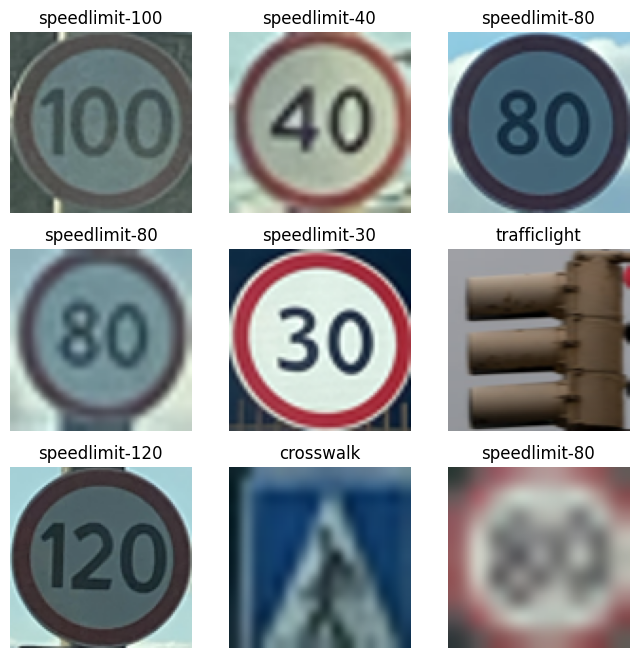

In [5]:
plt.figure(figsize=(8,8))
for i in range(9):
    idx = random.randint(0, len(X)-1)
    plt.subplot(3,3,i+1)
    plt.imshow(X[idx].astype("uint8"))
    plt.title(y_all[idx])
    plt.axis('off')
plt.show()


### Building the Dataset

All classifiers works best with values between 0 and 1.

Note that we are using the label "speedlimit" for classification between roadsigns, meaning label 1 will not appear on the final results (it is a placeholder for first classification).

In [6]:
X = X.astype("float32") / 255.0
X_flat = X.reshape(X.shape[0], -1)

label_encoder = LabelEncoder()
label_str = np.unique(y_all)
label_str = np.append(label_str, ["speedlimit"])
label_encoder.fit(label_str)
y_encoded_all = label_encoder.transform(y_all)

X_train, X_test, y_train_all, y_test_all = train_test_split(
    X_flat, y_encoded_all, test_size=0.2, random_state=7, stratify=y_encoded_all
)

print("Train :", X_train.shape, y_train_all.shape)
print("Test  :", X_test.shape, y_test_all.shape)
print("Classes :", label_encoder.classes_)

y_train = np.copy(y_train_all)
mask = np.isin(y_train, label_encoder.transform(["speedlimit", "crosswalk", "stop", "trafficlight"]))
y_train[~mask] = label_encoder.transform(["speedlimit"])[0]

y_test = np.copy(y_test_all)
mask = np.isin(y_test, label_encoder.transform(["speedlimit", "crosswalk", "stop", "trafficlight"]))
y_test[~mask] = label_encoder.transform(["speedlimit"])[0]

Train : (992, 27648) (992,)
Test  : (248, 27648) (248,)
Classes : ['crosswalk' 'speedlimit' 'speedlimit-100' 'speedlimit-120'
 'speedlimit-30' 'speedlimit-40' 'speedlimit-5' 'speedlimit-50'
 'speedlimit-60' 'speedlimit-70' 'speedlimit-80' 'speedlimit-90' 'stop'
 'trafficlight']


## Comparison of classifiers

### Multinomial Logistic Regression

Default max_iteration of LogisticRegression is 100 but it was not enough for the classifier to converge and made errors.

In [7]:
cls_lr = LogisticRegression(max_iter=200)
cls_lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


              precision    recall  f1-score   support

           0       0.93      0.93      0.93        40
           1       0.96      0.99      0.97       156
          12       0.89      0.94      0.92        18
          13       0.90      0.76      0.83        34

    accuracy                           0.94       248
   macro avg       0.92      0.91      0.91       248
weighted avg       0.94      0.94      0.94       248



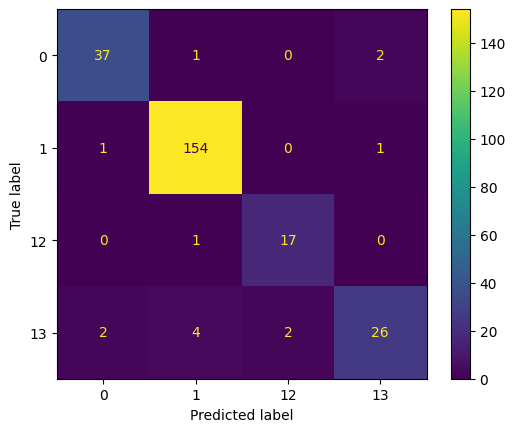

In [8]:
y_predicted_lr = cls_lr.predict(X_test)
print(classification_report(y_test, y_predicted_lr))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_lr)
plt.show()

### Support Vector Machine

In [9]:
cls_svm = svm.SVC()
cls_svm.fit(X_train,y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.98      1.00      0.99       156
          12       1.00      0.94      0.97        18
          13       0.94      0.88      0.91        34

    accuracy                           0.98       248
   macro avg       0.97      0.95      0.96       248
weighted avg       0.98      0.98      0.98       248



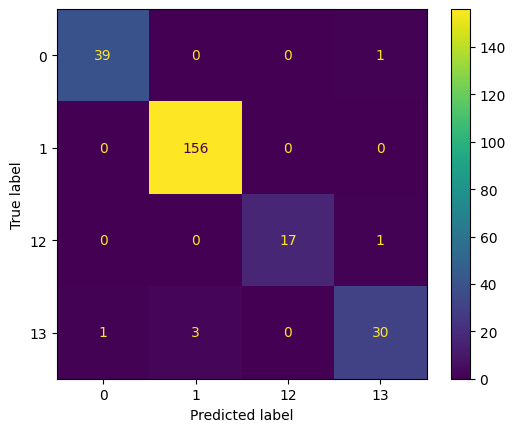

In [10]:
y_predicted_svm = cls_svm.predict(X_test)
print(classification_report(y_test, y_predicted_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_svm)
plt.show()

## Gaussian Naive Bayes

In [11]:
cls_gnb = GaussianNB()
cls_gnb.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


              precision    recall  f1-score   support

           0       0.74      0.88      0.80        40
           1       0.95      0.83      0.88       156
          12       0.84      0.89      0.86        18
          13       0.61      0.82      0.70        34

    accuracy                           0.84       248
   macro avg       0.79      0.85      0.81       248
weighted avg       0.86      0.84      0.84       248



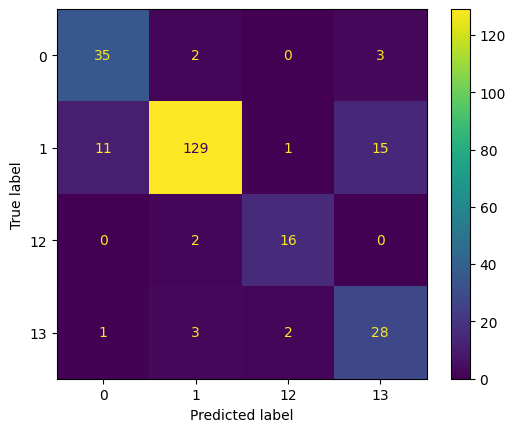

In [12]:
y_predicted_gnb = cls_gnb.predict(X_test)
print(classification_report(y_test, y_predicted_gnb))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_gnb, cmap='viridis')
plt.show()

## K Nearest Neighbors

Using the default parameters

In [13]:
cls_knn = KNeighborsClassifier(n_neighbors=5)
cls_knn.fit(X_train, y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.92      1.00      0.96       156
          12       1.00      1.00      1.00        18
          13       1.00      0.59      0.74        34

    accuracy                           0.94       248
   macro avg       0.97      0.88      0.91       248
weighted avg       0.94      0.94      0.93       248



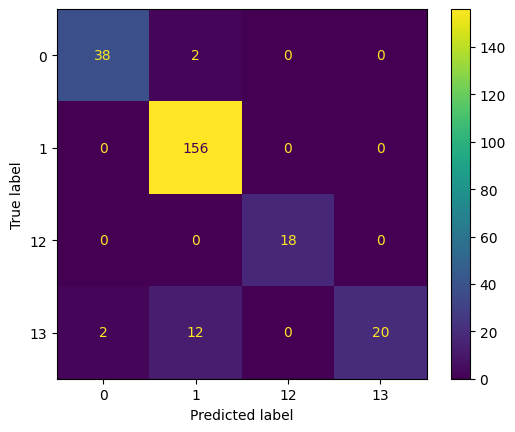

In [14]:
y_predicted_knn = cls_knn.predict(X_test)
print(classification_report(y_test, y_predicted_knn))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_knn)
plt.show()

Parameters tuning to find the best accuracy (simple brutefirce over $n$ and the weight function)

In [15]:
best_accuracy = 0
best_params = {}
for n_neighbors in range(1, 11):
    for weights in ['uniform', 'distance']:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        knn.fit(X_train, y_train)
        y_predicted_knn = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_predicted_knn)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_neighbors': n_neighbors, 'weights': weights}
print(f'Best accuracy: {best_accuracy}')
print(f'Best parameters: {best_params}')

Best accuracy: 0.9596774193548387
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}


## First Model Conclusion
We find that the best classifier is the Support Vector Machine with an accuracy of 98%, even if it take a long time to run on certain machines

# Second Model
Because the model was too inaccurate when we tried to work with all the different signs and different speedlimits, we chose to train the first model solely on the differentiation of sign types and to make a second model that would only train on the differentiation of speedlimits

## Building the dataset (speed limits)

In [16]:
y_train_sl = np.copy(y_train_all)
mask = np.isin(y_train_sl, label_encoder.transform(["speedlimit", "crosswalk", "stop", "trafficlight"]))
y_train_sl = y_train_all[~mask]
X_train_sl = X_train[~mask]

y_test_sl = np.copy(y_test_all)
mask = np.isin(y_test_sl, label_encoder.transform(["speedlimit", "crosswalk", "stop", "trafficlight"]))
y_test_sl = y_test_all[~mask]
X_test_sl = X_test[~mask]

print("Train speedlimit:", X_train_sl.shape, y_train_sl.shape)
print("Test speedlimit :", X_test_sl.shape, y_test_sl.shape)

Train speedlimit: (623, 27648) (623,)
Test speedlimit : (156, 27648) (156,)


## Training the second model
We compared each classifier and found out that the one with the best accuracy (92%) was the LogisticRegression classifier. Like in the first model we need to increase the value of maximum iterations so the model can converge, here it is 600 iterations.

In [17]:
cls_lr_sl = LogisticRegression(max_iter=600)
cls_lr_sl.fit(X_train_sl, y_train_sl)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,600
,multi_class,'deprecated'


              precision    recall  f1-score   support

           2       0.89      0.89      0.89        27
           3       0.93      1.00      0.97        14
           4       0.60      0.60      0.60         5
           5       0.91      0.98      0.95        44
           6       1.00      1.00      1.00         6
           7       1.00      0.50      0.67         6
           8       1.00      0.71      0.83         7
           9       1.00      0.80      0.89         5
          10       0.90      0.97      0.93        29
          11       1.00      1.00      1.00        13

    accuracy                           0.92       156
   macro avg       0.92      0.84      0.87       156
weighted avg       0.92      0.92      0.91       156



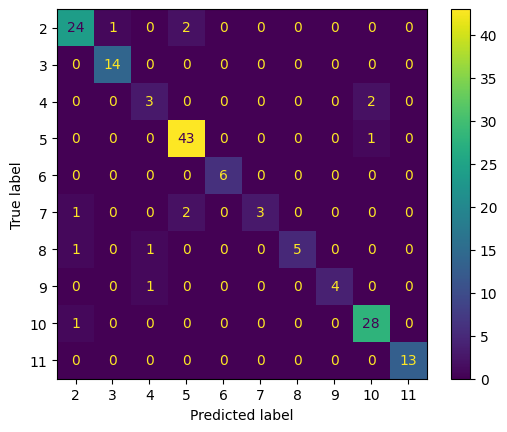

In [18]:
y_predicted_lr_sl = cls_lr_sl.predict(X_test_sl)
print(classification_report(y_test_sl, y_predicted_lr_sl))
ConfusionMatrixDisplay.from_predictions(y_test_sl, y_predicted_lr_sl)
plt.show()

## Combining the models
We then have to fuse both models to have a clean result at the end

### Replacing data to build the final prediction

In [19]:
y_predicted = np.copy(y_predicted_svm)
mask = np.isin(y_predicted, label_encoder.transform(["speedlimit"]))
y_predicted[mask] = cls_lr_sl.predict(X_test[mask])

### Confusion matrixes (recall)

Stage 1: Support Vector Machine, classification between road signs
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.98      1.00      0.99       156
          12       1.00      0.94      0.97        18
          13       0.94      0.88      0.91        34

    accuracy                           0.98       248
   macro avg       0.97      0.95      0.96       248
weighted avg       0.98      0.98      0.98       248



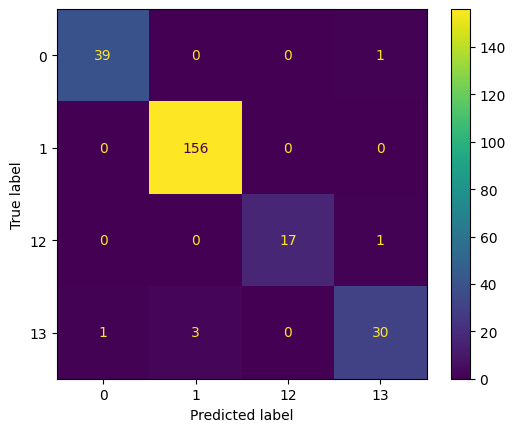

Stage 2: Logistic Regression, classification between speed limits (classified by the stage 1)
              precision    recall  f1-score   support

           2       0.89      0.89      0.89        27
           3       0.93      1.00      0.97        14
           4       0.60      0.60      0.60         5
           5       0.91      0.98      0.95        44
           6       1.00      1.00      1.00         6
           7       1.00      0.50      0.67         6
           8       1.00      0.71      0.83         7
           9       1.00      0.80      0.89         5
          10       0.90      0.97      0.93        29
          11       1.00      1.00      1.00        13

    accuracy                           0.92       156
   macro avg       0.92      0.84      0.87       156
weighted avg       0.92      0.92      0.91       156



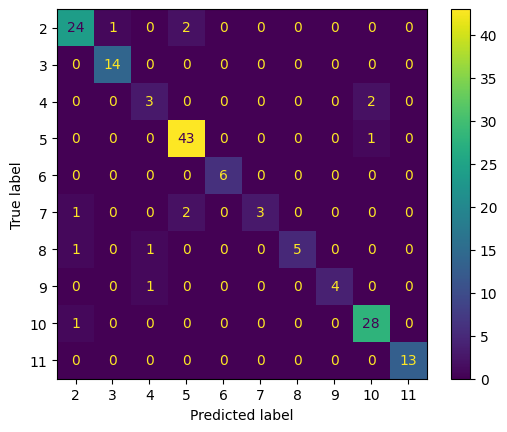

Total: classification between road signs and speed limits
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           2       0.86      0.89      0.87        27
           3       0.93      1.00      0.97        14
           4       0.50      0.60      0.55         5
           5       0.91      0.98      0.95        44
           6       1.00      1.00      1.00         6
           7       1.00      0.50      0.67         6
           8       1.00      0.71      0.83         7
           9       1.00      0.80      0.89         5
          10       0.90      0.97      0.93        29
          11       0.93      1.00      0.96        13
          12       1.00      0.94      0.97        18
          13       0.94      0.88      0.91        34

    accuracy                           0.92       248
   macro avg       0.92      0.87      0.88       248
weighted avg       0.93      0.92      0.92       248



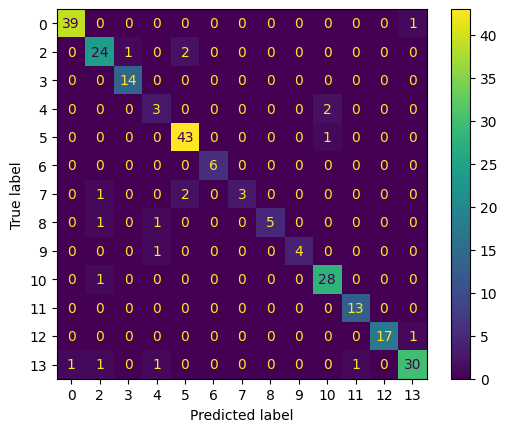

In [20]:
print("Stage 1: Support Vector Machine, classification between road signs")

print(classification_report(y_test, y_predicted_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_svm)
plt.show()

print("Stage 2: Logistic Regression, classification between speed limits (classified by the stage 1)")

print(classification_report(y_test_sl, y_predicted_lr_sl))
ConfusionMatrixDisplay.from_predictions(y_test_sl, y_predicted_lr_sl)
plt.show()

print("Total: classification between road signs and speed limits")

print(classification_report(y_test_all, y_predicted))
ConfusionMatrixDisplay.from_predictions(y_test_all, y_predicted)
plt.show()

## Conclusion
By combining both our model we find a global accuracy of 93%, which is way better than the ~80% of a single model trained on every type of signs and every speedlimits.

### After obtaining the satisfying accuracy display numbers which the model misclassified.

Total number of missclassification : 19


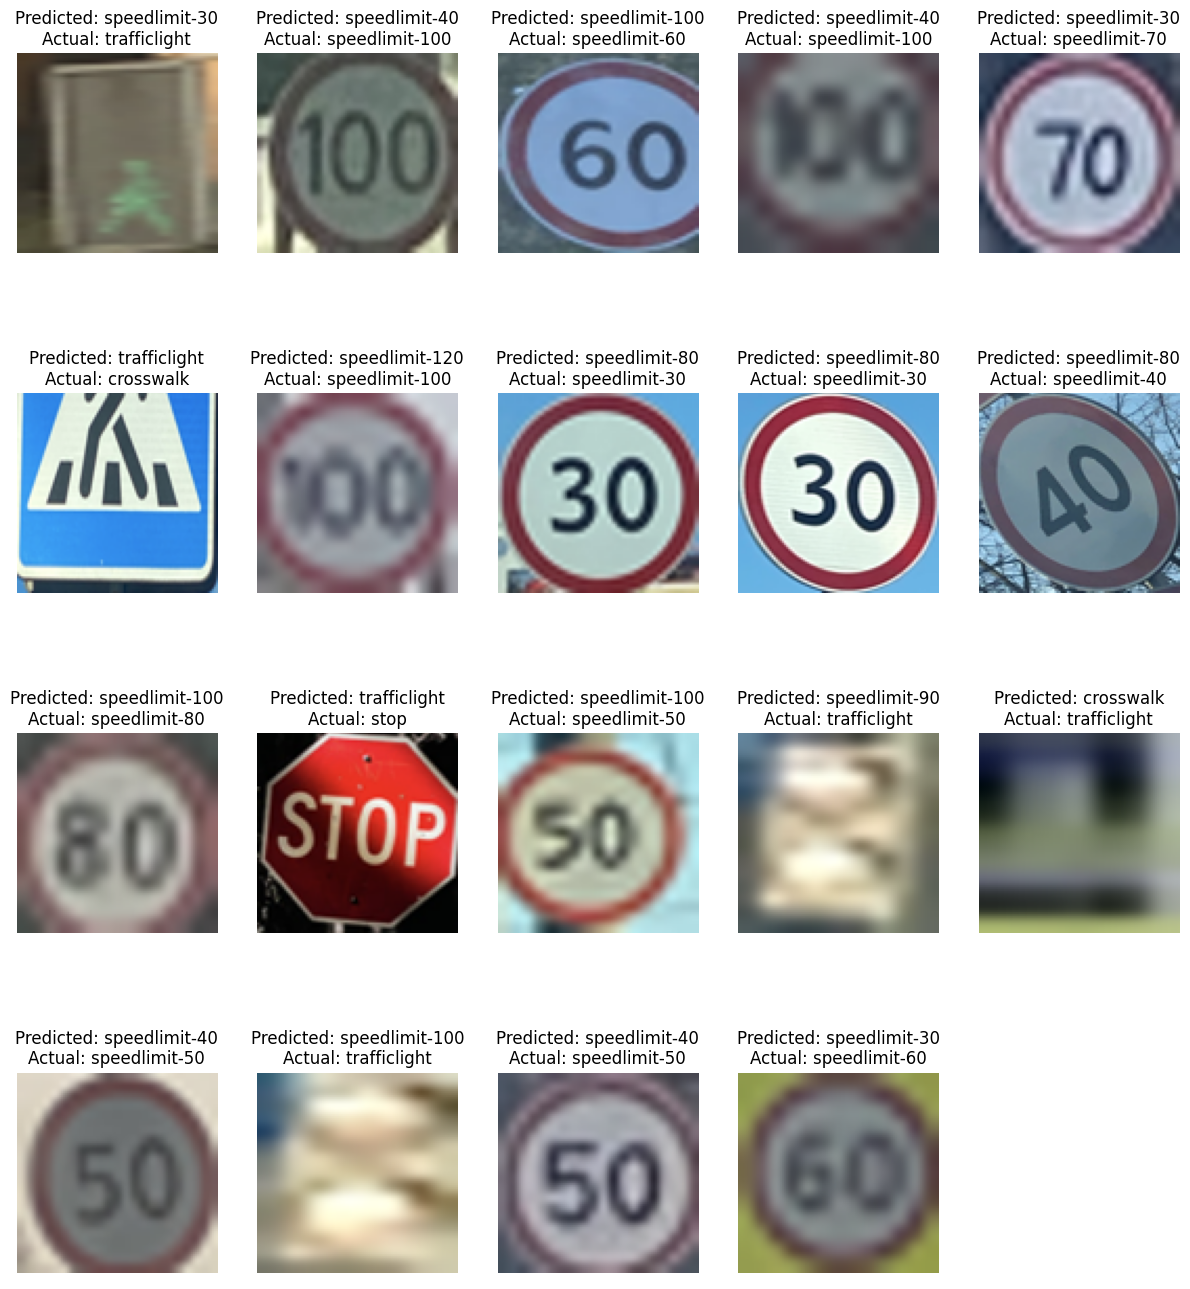

In [21]:
y_missclassified_mask = y_predicted != y_test_all

print("Total number of missclassification :", y_missclassified_mask.sum())

y_missclassified_computed = label_encoder.inverse_transform(y_predicted[y_missclassified_mask])
y_missclassified_test = label_encoder.inverse_transform(y_test_all[y_missclassified_mask])
X_missclassified = X_test[y_missclassified_mask]

n = len(y_missclassified_computed)

X_missclassified = (X_missclassified.astype("float32") * 255.0).astype("uint8")

rows = (n + 4) // 5
fig, axes = plt.subplots(nrows=rows, ncols=5, figsize=(15, rows * 4))
for i in range(n):
    plt.subplot(rows, 5, i+1)
    plt.imshow(X_missclassified[i].reshape(96, 96, 3))
    plt.title("Predicted: " + y_missclassified_computed[i] + "\nActual: " + y_missclassified_test[i])
    plt.axis('off')
    plt.subplots_adjust(hspace=0.6)


# Hide unused plot spots at the end
for j in range(n, rows * 5):
    axes.flatten()[j].axis('off')

plt.show()
